In [19]:
import os

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from matplotlib import cm
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from models import Generator, Discriminator


In [20]:
# ======== HYPERPARAMETERS ========
latent_dim = 100
batch_size = 512
epochs = 300
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
# ======== DATASET ========
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # scale to [-1, 1]
])

fixed_labels = torch.arange(10).to(device)  # shape: [10]

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [18]:
# ======== INIT ========
G = Generator().to(device)
D = Discriminator().to(device)

opt_D = optim.Adam(D.parameters(), lr=0.0001)  # slower D
opt_G = optim.Adam(G.parameters(), lr=0.0002)  # faster G

D_loss = torch.tensor(0.0, device=device)
G_loss = torch.tensor(0.0, device=device)

[Epoch 1/300] D_loss: 1.8958 G_loss: 0.2337


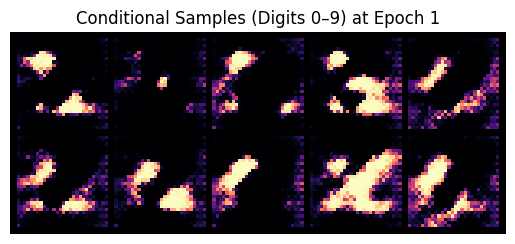

[Epoch 2/300] D_loss: 1.6431 G_loss: 0.4085


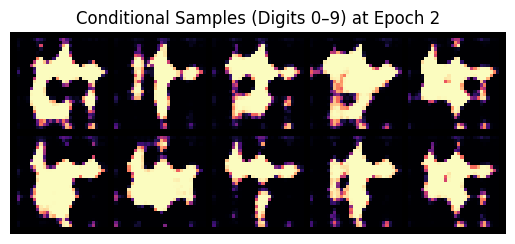

[Epoch 3/300] D_loss: 1.4026 G_loss: 0.6435


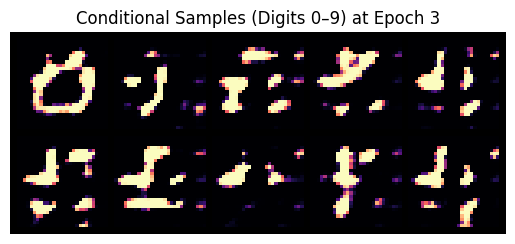

[Epoch 4/300] D_loss: 1.2751 G_loss: 0.7337


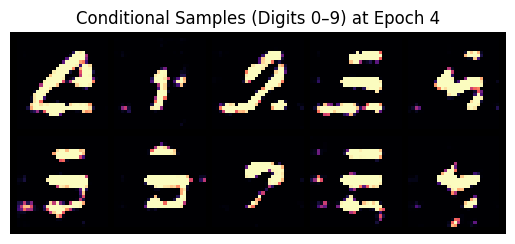

[Epoch 5/300] D_loss: 0.2181 G_loss: 1.1661


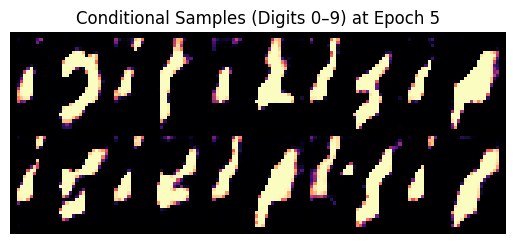

[Epoch 6/300] D_loss: 0.8306 G_loss: 0.9081


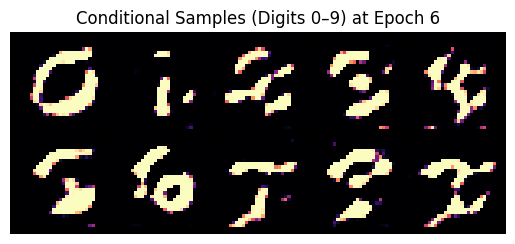

[Epoch 7/300] D_loss: 0.5726 G_loss: 1.1499


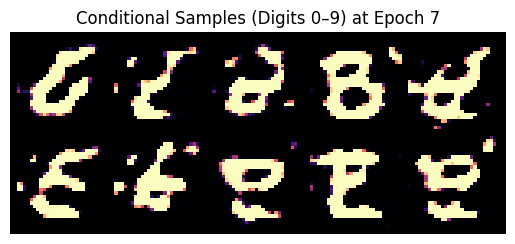

[Epoch 8/300] D_loss: 0.4414 G_loss: 1.1338


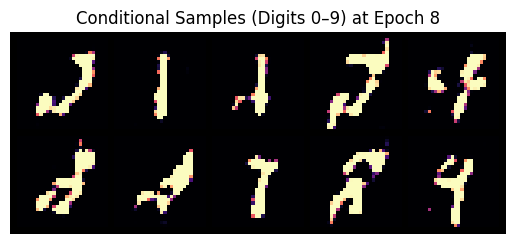

In [ ]:
# ======== TRAINING LOOP ========
for epoch in range(epochs):
    for i, (real_imgs, labels) in enumerate(loader):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        batch_size = real_imgs.size(0)

        # === Train Discriminator ===
        fake_imgs = G(labels).detach()

        noise_strength = max(0.1 * (1 - epoch / 50), 0.02)  # decay over time
        real_imgs += noise_strength * torch.randn_like(real_imgs)
        fake_imgs += noise_strength * torch.randn_like(fake_imgs)

        # Use hinge loss
        real_loss = torch.relu(1.0 - D(real_imgs, labels)).mean()
        fake_loss = torch.relu(1.0 + D(fake_imgs, labels)).mean()
        D_loss = real_loss + fake_loss

        opt_D.zero_grad()
        D_loss.backward()
        torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=1.0)
        opt_D.step()

        # === Train Generator ===
        gen_imgs = G(labels)
        real_targets = torch.ones(batch_size, 1, device=device)

        # Use hinge loss
        G_loss = -D(gen_imgs, labels).mean()

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

    print(f"[Epoch {epoch + 1}/{epochs}] D_loss: {D_loss.item():.4f} G_loss: {G_loss.item():.4f}")

    # === Save model checkpoints ===
    os.makedirs("checkpoints", exist_ok=True)
    torch.save(G.state_dict(), f"checkpoints/G_epoch_latest.pt")
    torch.save(D.state_dict(), f"checkpoints/D_epoch_latest.pt")

    # === Show sample ===
    with torch.no_grad():
        G.eval()
        samples = G(fixed_labels).cpu()  # shape: [10, 1, 28, 28]
        G.train()

        # Apply magma colormap to each sample
        colored_samples = []
        for img in samples:
            img = img.squeeze(0)  # [28, 28]
            img = (img + 1) / 2  # normalize from [-1, 1] → [0, 1]
            img_np = img.numpy()

            # Apply magma colormap and ignore alpha
            img_magma = cm.magma(img_np)[..., :3]  # [H, W, 3]
            img_tensor = torch.tensor(img_magma).permute(2, 0, 1)  # [3, H, W]
            colored_samples.append(img_tensor)

        # Stack and grid the batch
        colored_batch = torch.stack(colored_samples)  # [10, 3, 28, 28]
        grid = make_grid(colored_batch, nrow=5)  # 5x2 layout

        # Display
        plt.imshow(grid.permute(1, 2, 0))  # CHW → HWC
        plt.axis('off')
        plt.title(f"Conditional Samples (Digits 0–9) at Epoch {epoch + 1}")
        plt.show()